example took it from https://fenicsproject.org/olddocs/dolfin/latest/python/demos/mixed-poisson/demo_mixed-poisson.py.html

In [1]:
import fenics as fn
from matplotlib import pyplot as plt

system:
$$
\left\{ \begin{array}{rll}
\sigma + \nabla u &= 0 & \text{in } \Omega \\
\nabla \cdot \sigma &= f & \text{in } \Omega \\
u &=u_0 & \text{on } \Gamma_D \\
-\sigma \cdot n &=g & \text{on } \Gamma_N
\end{array}\right.
$$

Then, we need to create a <code>Mesh</code> covering the unit square. In this example, we will let the mesh consist of $32 \times 32$ squares with each square divided into two triangles:

In [2]:
mesh = fn.UnitSquareMesh(32,32)

Next, we need to build the function space.

In [3]:
# Define finite elements spaces and build mixed space
BDM = fn.FiniteElement("BDM", mesh.ufl_cell(), 1)
DG  = fn.FiniteElement("DG", mesh.ufl_cell(), 0)
W   = fn.FunctionSpace(mesh, BDM * DG)

The second argument to <code>>FunctionSpace</code> specifies underlying finite element, here mixed element obtained by $*$ operator.
$$W=\{(τ,v) \text{ such that } \tau \in \text{BDM},v\in \text{DG}\}$$
Next, we need to specify the trial functions (the unknowns) and the test functions on this space. This can be done as follows:

In [4]:
# Define trial and test functions
(sigma, u) = fn.TrialFunctions(W)
(tau, v)   = fn.TestFunctions(W)

In order to define the variational form, it only remains to define the source function $f$.
.

In [5]:
# Define source function
f = fn.Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", 
                  degree=2)

We are now ready to define the variational forms a and L. Since, $u_0=0$ in this example, the boundary term on the right-hand side vanishes.

In [6]:
# Define variational form
a = (fn.dot(sigma, tau) + fn.div(tau)*u + fn.div(sigma)*v)*(fn.dx)
L = - f*v*(fn.dx)

It only remains to prescribe the boundary condition for the flux. Essential boundary conditions are specified through the class <code>DirichletBC</code> which takes three arguments: the function space the boundary condition is supposed to be applied to, the data for the boundary condition, and the relevant part of the boundary.

We want to apply the boundary condition to the first subspace of the mixed space. Subspaces of a mixed <code>FunctionSpace</code> can be accessed by the method <code>sub</code>. In our case, this reads <code>W.sub(0)</code>. (Do not use the separate space <code>BDM</code> as this would mess up the numbering.)

Next, we need to construct the data for the boundary condition. An essential boundary condition is handled by replacing degrees of freedom by the degrees of freedom evaluated at the given data. The $BDM$
 finite element spaces are vector-valued spaces and hence the degrees of freedom act on vector-valued objects. The effect is that the user is required to construct a $G$ such that $G\cdot n=g$. Such a $G$
 can be constructed by letting $G=gn$. In particular, it can be created by subclassing the <code>Expression</code> class. Overloading the <code>eval_cell</code> method (instead of the usual <code>eval</code>) allows us to extract more geometry information such as the facet normals. Since this is a vector-valued expression, we also need to overload the <code>value_shape</code> method.

In [7]:
# Define function G such that G \cdot n = g
class BoundarySource(fn.UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = fn.Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = fn.sin(5*x[0])
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)

G = BoundarySource(mesh, degree=2)

Specifying the relevant part of the boundary can be done as for the Poisson demo (but now the top and bottom of the unit square is the essential boundary):

In [8]:
# Define essential boundary
def boundary(x):
    return x[1] < fn.DOLFIN_EPS or x[1] > 1.0 - fn.DOLFIN_EPS

Now, all the pieces are in place for the construction of the essential boundary condition:

In [9]:
bc = fn.DirichletBC(W.sub(0), G, boundary)

To compute the solution we use the bilinear and linear forms, and the boundary condition, but we also need to create a <code>Function</code> to store the solution(s). The (full) solution will be stored in the $w$, which we initialise using the <code>FunctionSpace</code> $W$. The actual computation is performed by calling <code>solve</code>. The separate components $\sigma$ and $u$ of the solution can be extracted by calling the <code>split</code> function. Finally, we plot the solutions to examine the result.

In [10]:
# Compute solution
w = fn.Function(W)
fn.solve(a == L, w, bc)
(sigma, u) = w.split()

Solving linear variational problem.


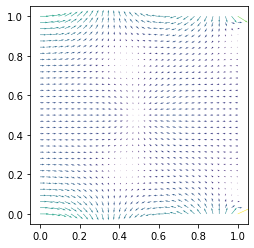

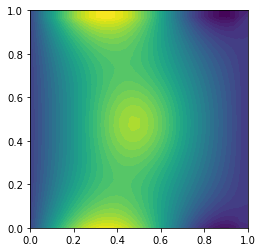

In [11]:
# Plot sigma and u
plt.figure()
fn.plot(sigma)

plt.figure()
fn.plot(u)

plt.show()